#### note for carmen
include this in references, used a lot of it in running pca/pls
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11/Lab%2011%20-%20PCR%20and%20PLS%20Regression%20in%20Python.pdf

In [1]:
%matplotlib inline
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load in ames home price train and test data
ames_train = pd.read_csv("ames_train.csv")
ames_test = pd.read_csv("ames_test.csv")

In [3]:
# merge both files first so there are the same number of categories created
ames_merged = pd.concat([ames_train, ames_test])
ames_merged = pd.get_dummies(ames_merged).drop(["price", "PID"], axis = 1).fillna(value=0)

In [4]:
# convert categorical variables to dummy variables
# create variables for train and test data separately, x for predictors, y for response

x_predictors_train = ames_merged[0:1500]
x_predictors_test = ames_merged[1500:2000]

y_train = ames_train.price
y_test = ames_test.price

### Algorithm: Partial Least Squares

In [ ]:
import numpy as np
import pandas as pd

###Mean center and scale data##

#Load data
path = 'ames_train.csv'
data = pd.DataFrame.from_csv(path)
data = data[["price", "Lot.Area", "MS.SubClass", "Yr.Sold"]] #Take price, Lot.Area, MS.SubClass, and Yr.Sold as a dataframe
price_std = data["price"].std()

#Subtract the mean from each column
data = data - data.mean()

#Scale each column by the column standard deviation
data = data/data.std()

#Separate in to design matrix (X block) and response column vector (Y block)
X = data[["Lot.Area", "MS.SubClass", "Yr.Sold"]].as_matrix()
Y = data[["price"]].as_matrix()

In [ ]:
#SEE PAGE 16

#Here we have one variable in the Y block so q = 1 
#and omit steps 5-8
q = 1

#For the X block, u = Y
u = Y #random y column from Y #Step 1
w_old = np.dot(u.T,X)/np.dot(u.T,u) #Step 2
w_new = w_old/np.linalg.norm(w_old) #Step 3
t = np.dot(X,w_new.T)/np.dot(w_new,w_new.T) #Step 4

#For the Y block can be omitted if Y only has one variable
q_old = np.dot(t.T,Y)/np.dot(t.T,t) #Step 5
q_new = q_old/np.linalg.norm(q_old) #Step 6
u = np.dot(Y,q_new.T)/np.dot(q_new,q_new.T) #Step 7

#Step 8: Check convergence

#Calculate the X loadings and rescale the scores and weights accordingly
p = np.dot(t.T,X)/np.dot(t.T,t) #Step 9
p_new = p.T/np.linalg.norm(p.T) #Step 10
t_new = t/np.linalg.norm(p.T) #Step 11
w_new = w_old/np.linalg.norm(p)  #Step 12

#Find the regression coefficient for b for th inner relation
b = np.dot(u.T,t_new)/np.dot(t.T,t) #Step 13
b

#Calculation of the residuals
E_h = X - np.dot(t_new,p_new.T)
#F_h = Y - b.dot(t_new).dot(q.T) #NOT WORKING
F_h = Y - b.dot(t_new.T).T.dot(q) #WORKS BUT IS THIS RIGHT?

RMSE = np.sqrt(sum((F_h)**2)/F_h.shape[0]) 
print(RMSE * price_std) # I believe this is the RMSE since the Y had to be scaled.

print(X.shape) #X matrix
print(t_new.shape) # t column vector
print(u.shape) # u column vector
print(Y.shape) #Y "matrix" but column vector because only 1 Y variable
print(p.shape) # p transpose row vector
print(b.shape) # b scalar
print(q_new.shape) # q transpose row vector
print(w_new.shape) # w transpose row vector

### Alternative Algorithm: PCA

In [5]:
# speed of pca algorithm
pca_start = timeit.default_timer()

# scale x train data
x_scaled_train = PCA().fit_transform(scale(x_predictors_train))
n = len(x_scaled_train)

# perform cross validation (10 k-fold)
cross_val_k_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)
pca_rmse = []

# calculate rmse values for intercept (no predictors/components)
mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), np.ones((n,1)), y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
pca_rmse.append(sqrt(mean_sq_error))

# calculate rmse values for varying numbers of predictors/components
for i in range(1, len(x_predictors_train.columns)):
    mean_sq_error = -1*cross_validation.cross_val_score(lin_reg(), x_scaled_train[:,:i], y_train.ravel(), cv = cross_val_k_10, scoring = "neg_mean_squared_error").mean()
    pca_rmse.append(sqrt(mean_sq_error))

# find number of principal components with smallest rmse
n_pca_comps = pca_rmse.index(min(pca_rmse))

# run regression using specific number of principal components
pca_reg = lin_reg().fit(x_scaled_train[:,:n_pca_comps], y_train)

# use regression above to predict on test data
x_scaled_test = PCA().fit_transform(scale(x_predictors_test))[:,:n_pca_comps]
y_test_pred_pca = pca_reg.predict(x_scaled_test)
pca_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_pca))
    
pca_speed = timeit.default_timer() - pca_start

(20000, 200000)

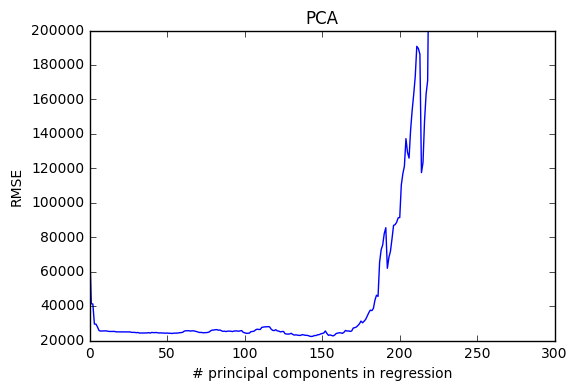

In [6]:
plt.plot(pca_rmse)
plt.title("PCA")
plt.xlabel("# principal components in regression")
plt.ylabel("RMSE")
plt.ylim(ymin = 20000, ymax = 200000)

### Simple Algorithm: OLS

In [7]:
# speed of algorithm
ols_start = timeit.default_timer()

# run ols on home price model
ols_reg = lin_reg().fit(x_predictors_train, y_train)
y_test_pred_ols = ols_reg.predict(x_predictors_test)
ols_rmse_test = sqrt(mean_squared_error(y_test, y_test_pred_ols))

ols_speed = timeit.default_timer() - ols_start

In [8]:
# summary of all methods, accuracy and speed
diff_methods_summary = {'RMSE' : [1111., pca_rmse_test, ols_rmse_test], 'Speed' : [1111, pca_speed, ols_speed]}
pd.DataFrame(diff_methods_summary, index=['PLS', 'PCA', 'OLS'])

,RMSE,Speed
PLS,1.111000e+03,1111.000000
PCA,6.537511e+04,33.981717
OLS,2.524432e+08,0.054082


### Description of algorithm

PLS is a regression method used to overcome limitations discussed above for normal linear regressions (e.g., many collinear predictors, more predictors than samples, etc.) by mapping observed sets of observed variables to response variables by means of latent variables. Essentially the model assumes that the data is generated by an underlying model directed by a smaller number of latent variables in the data. 

First, two sets of latent variables are extracted from the data: $T$ (or x-scores) from the predictors, and $U$ (or y-scores) from the response variable. These latent vectors are determined through maximizing the covariance between different sets of variables. 

For the classic linear regression, we try to solve the equation, $ Y = XB + {\epsilon} $, where the ordinary least squares estimate for ${\beta}$ is identified as ${(X^T X)}^{-1} X^TY$. This estimate is obtained by minimizing the sum of squared residuals. However, models that have predictors with high collinearity or more predictors than observations can result in singularity of the matrix ${(X^T X)}$. As an alternative and way to fix this issue, we implement the PLS algorithm throught the following steps:

1) Start with vector $u$. If there is only one response variable, then $ u = y $, otherwise it is one of the columns of $Y$.

2) Calculate the weights for the predictors ($X$) :
$$ w = \frac{X^Tu}{u^Tu} $$

3) Determine $t$ ($X$ scores):
$$ t = Xw $$

4) Now perform similar calculations for $Y$. Calculate the weights for the response variable:
$$ c = \frac{X^Tt}{t^Tt} $$

5) Determine $u$ ($Y$ scores):
$$ u = \frac{Yc}{c^Tc} $$

6) If there is more than one response variable, then we test to determine whether the $t$ values have converged. If the change in $t$ from one iteration to the next, $ \frac{||t_{old} - t_{new}}{||t_{new}||} $, is not smaller than a threshold value, then we iterate through steps 2-5 until convergence is reached.

7) Deflate variables for next iteration.
$$ p = \frac{X^Tt}{t^Tt} $$
$$ X = X - tp^T $$
$$ Y = Y - tc^T $$

8) Iterate through components until they are not found to be predictive of $Y$.